### Uncomment and run the below code block if you do not already have the below libraries installed.

In [3]:
# !pip install sklearn
# !pip install pandas

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
import collections
import time
from sklearn import decomposition
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import LogisticRegression 
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline
print(sklearn.__version__)

1.0.2


In [6]:
# make sure your data matches the given name below, else edit it to desired name
# note: csv is assumed to be stored in /content/ . Change path if necessary
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/MUM_data_modi.csv')
# check that the data is imported properly
df.head()

,SM,MM,shader,core,spunit,l1,latency,dl2,IPC
0,2,2,3,24,1024,32,35,128,2.2625
1,2,2,1,12,1024,32,35,64,2.2381
2,2,2,3,48,1024,64,82,64,2.3809
3,2,2,1,12,2048,32,20,64,2.2526
4,2,2,4,48,1024,64,20,64,2.3829


### Exploratory Data Analysis:

In [7]:
df.mean()

SM            3.951538
MM            1.446412
shader        2.250699
core         27.343896
spunit     1536.477167
l1           47.955266
latency      45.515377
dl2          96.208760
IPC           2.023505
dtype: float64

In [8]:
df.median()

SM            3.0000
MM            1.0000
shader        2.0000
core         24.0000
spunit     1536.0000
l1           32.0000
latency      35.0000
dl2         128.0000
IPC           1.8968
dtype: float64

In [9]:
df.tail()

,SM,MM,shader,core,spunit,l1,latency,dl2,IPC
1068,15,1,1,24,2048,32,82,128,1.8955
1069,15,1,1,12,2048,64,35,128,1.8965
1070,15,1,1,24,1024,64,82,64,1.8956
1071,15,1,1,48,2048,32,82,64,1.8956
1072,15,1,1,12,1024,32,82,64,1.8956


In [10]:
df.describe()

,SM,MM,shader,core,spunit,l1,latency,dl2,IPC
count,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000,1073.000000
mean,3.951538,1.446412,2.250699,27.343896,1536.477167,47.955266,45.515377,96.208760,2.023505
std,3.257236,0.528276,1.139341,14.895222,419.311460,16.007398,26.338532,32.014241,0.377115
min,2.000000,1.000000,1.000000,12.000000,1024.000000,32.000000,20.000000,64.000000,1.413900
25%,2.000000,1.000000,1.000000,12.000000,1024.000000,32.000000,20.000000,64.000000,1.793000
50%,3.000000,1.000000,2.000000,24.000000,1536.000000,32.000000,35.000000,128.000000,1.896800
75%,3.000000,2.000000,3.000000,48.000000,2048.000000,64.000000,82.000000,128.000000,2.267500
max,15.000000,3.000000,4.000000,48.000000,2048.000000,64.000000,82.000000,128.000000,3.761600


In [11]:
df.shape

(1073, 9)

###Functions

In [12]:
#functions
def x_y_split(dataset, data_start, data_end, target_index):
    x_data = dataset[:, data_start:data_end+1]
    y_data = dataset[:, target_index]
    return x_data, y_data

def exclude_from_set(dataset, value, column_index, data_start, data_end, target_index):
    rows = dataset[np.where(dataset[:, column_index] != value)]
    x_data = rows[:, data_start:data_end+1]
    y_data = rows[:, target_index]
    
    return x_data, y_data

def x_y_split_by_value(dataset, value, column_index, data_start, data_end, target_index):
    rows = dataset[np.where(dataset[:, column_index] == value)]
    x_data = rows[:, data_start:data_end+1]
    y_data = rows[:, target_index]
    
    return x_data, y_data

def random_forest_n_runs_feat_importance(x_data, y_data, forest_model, runs, features):
    feature_importance_array = []
    
    for i in range(features):
        feature_importance_array.append(np.zeros(runs))
    
    for run in range(0, runs):
        forest_model.fit(x_data, y_data)
        importances = forest_model.feature_importances_
        for k in range(features):
            feature_importance_array[k][run] = importances[k]
        #print(importances)
    #print(feature_importance_array)
    return feature_importance_array

def group_dataset(dataset, target_index):
    group_data = dataset[:, target_index]
    return group_data

In [13]:
#machine learning functions
from sklearn.model_selection import LeaveOneGroupOut,StratifiedShuffleSplit, LeavePGroupsOut, GridSearchCV,GroupKFold,KFold, GroupShuffleSplit
from sklearn.model_selection import RandomizedSearchCV, LeaveOneOut, ShuffleSplit, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LassoCV, Lasso, RidgeCV, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np
import math
from sklearn.svm import SVC, SVR
#write functions

import warnings
warnings.filterwarnings('ignore')
# to filter out warnings at this time

def outer_cross_val(X, Y, validation_method, model, params ,\
                    model_type = 'Regression', min_samples = 10):
    #X - test data
    #Y - test data true results
    #groups - what to split the test data based on
    #validation_method - how to split the data for validation
    #model_params: model, model_type, params
    #model: the model used for machine learning
    #params: Pass in to nested function for GridSearchCV
    #model_type: Regression or Classification
    #min_samples: min number of samples on the test set to consider the model
    #function returns the best model overall and a collection of scoring and data
    print("Outer Cross Validation")
    
    labels_matrix = np.unique(Y)
    #print(labels_matrix)
    #print(len(labels_matrix))
    consolidated_confusion_matrix = np.zeros((len(labels_matrix), len(labels_matrix)))
    best_confusion_matrix = np.zeros((len(labels_matrix), len(labels_matrix)))
    #based on the model type, score differently'
    if model_type == 'Regression':
        best_score = 10000 #using root mean squared error, so lower score is better
    elif model_type == 'Classification':
        best_score = 0 #using accuracy, so higher score is better
    count = 0
    total_score = 0
    for train_index, test_index in validation_method.split(X, Y):
        #for each group split, do a nested cross validation
        #print(test_index)
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        # nested_groups = groups[train_index]
        
        #optmized model from training set (validation done in nested function)
        best_nested_model = nested_cross_val(X_train, Y_train, \
                                            validation_method, model, params)
        #print the parameters for the model in the nested 
        
        print('best_nested_model: ', best_nested_model)
        #fitting the model with training data
        best_nested_model.fit(X_train,Y_train)
        
        Y_pred = best_nested_model.predict(X_test)
        
        Y_pred_q = np.round_(Y_pred, decimals = 0)
        # print('Y_pred: ', Y_pred)
        print('Y_pred_q: ', Y_pred_q)
        
        # nested_score = metrics.mean_squared_error(Y_test, Y_pred)
        # print(math.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
        
        # nested_score = rsme(Y_test, Y_pred)
        # print('nested_score: ', nested_score)

        # # Classification part
        nested_accuracy = metrics.accuracy_score(Y_test, Y_pred_q)
        print('nested_accuracy: ', nested_accuracy)
        nested_f1 = metrics.f1_score(Y_test, Y_pred, average='weighted')
        #compile all results for the confusion matrix
        consolidated_confusion_matrix += metrics.confusion_matrix(Y_test, Y_pred_q, \
                                            labels=labels_matrix)
        print('Y_test: ', Y_test)
       # print(min_samples)
        print('best_score_ before: ', best_score)
        if model_type == 'Regression':
            #if regression, compare mean squared error, the lower the better
            if best_score > nested_score and len(Y_test) >= min_samples:
            #compare metrics if the number of test cases are greater than 10:
                best_model_overall = best_nested_model
                best_score = nested_score
                best_y_test = Y_test
                best_y_pred = Y_pred
            total_score += nested_score
        elif model_type == 'Classification':
            #if classification, compare accuracy
            if best_score < nested_accuracy and len(Y_test) >= min_samples:
                best_model_overall = best_nested_model
                best_score = nested_accuracy
                best_y_test = Y_test
                best_y_pred = Y_pred
            total_score += nested_accuracy
        
        print('best_score_ after: ', best_score)
        count += 1
        
    average_score = total_score/count
                    
    final_scoring = best_score, average_score, consolidated_confusion_matrix, best_y_test, best_y_pred
    # final_scoring = best_score, average_score, best_y_test, best_y_pred

  
    return best_model_overall, final_scoring


def nested_cross_val(X, Y, validation_method, model, params):
    #print("Inner Cross Validation")
    #X, Y, cross validation split method object, model
    # use GridSearchCV to look for the best model
    test_model = GridSearchCV(model, params, cv = validation_method.split(X, Y)).fit(X, Y)
    #print(test_model.best_estimator_)
    #print(test_model.scorer_)
    return test_model.best_estimator_
    
def rsme(predictions, target):
    #root squared mean error
    return np.sqrt(((predictions - target) **2).mean())

#calculate the accuracy from a confusion matrix
def accuracy_from_confusion_matrix(matrix):
    tp = np.diag(matrix).sum() #true positive
    total = matrix.sum()
    #print(tp)
    #print(total)
    return(tp*1.0/total)

#use the binom class from scipi
from scipy.stats import binom

def binomial_range(x, N, confidence_level = 0.95):
    #print("Calculate Binomal")
    #c_high = 1 - (confidence_level/2)
    #c_low = 1 - (confidence_level/2)
    prob = (x*1.0)/N
    #use the scipy binom.interval function to get the confidence range
    nums = binom.interval(confidence_level, N, prob)
    return nums[0]/N, nums[1]/N
    #exact_confidence_interval(x, N, c_high, c_low)
    
def matrix_scores(matrix):
    print("Extracting Confidence Intervals scores for the matrix")
    #do count through the matrix for the confidence scores.
    #matrix is expected to be a n x n matrix
    matrix_results = []
    for i in range(len(matrix[0])):
        #print(i)
        tp = matrix[i,i]
        fn = np.sum(matrix[i]) - tp
        fp = np.sum(matrix[:, i]) -tp
        #print("tp %d" %tp)
        #print("fp %d" %fp)
        #print("fn %d" %fn)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        print("overall precision: %.8f, recall: %.8f" % (precision, recall))
        #with binomial ranges
        precision_b_low, precision_b_high = binomial_range(tp, tp+fp)
        recall_b_low, recall_b_high = binomial_range(tp, tp+fn)
        print("precision range for %i: %.8f to %.8f" % (i +1, precision_b_low, precision_b_high))
        print("recall range for %i: %.8f to %.8f" % (i +1, recall_b_low, recall_b_high))
        matrix_results.append([[precision_b_low, precision_b_high], [recall_b_low, recall_b_high]])
    return matrix_results

###Confusion Matrix

In [14]:
import seaborn as sns
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html     
    title:         Title for the heatmap. Default is None.
    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    #plt.savefig(plt.savefig((r'C:\Users\te5msride\OneDrive\Documents\Manuscript\Figures\ClassCM.svg' )))

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

###SVR

In [ ]:
data_arr = df.to_numpy()
X, Y = x_y_split(data_arr, 0, 6, 7)
# Y = Y.astype(float) # cast Y as floats
# labels_for_matrix = np.unique(Y)
#generate features for the paper draft, and include reasons why that was done 

In [ ]:
print([pow(10,i) for i in range(8,-5, -1)])

In [ ]:
#support vector regressor
testing = 'Regression'
selection = KFold()
SVR_sub = []
to_excel =[]
results = []
nested = False

print("Support vector regressor")

# params_svr = {'gamma':[pow(10,i) for i in range(8,-5, -1)], 'C':[pow(10,j) for j in range(-5, 5, 1)]}
params_svr = {'gamma':[10000, 1000, 100, 10, 1, 0.1, 0.01],'C':[0.001, 0.01, 0.1, 1, 10, 100]}


best_SVR, SVR_scoring = outer_cross_val(X, Y, selection, SVR(), params_svr, 'Regression')

SVR_score, average_SVR, Y_test, Y_pred = SVR_scoring
# SVR_score, average_SVR, SVR_cm, Y_test, Y_pred, _, _, ok1, ok2 = SVR_scoring

Y_pred_q = np.round_(Y_pred, decimals = 0)
print("best score: %.6f" % SVR_score)
print("average score: %.6f " % average_SVR)
# best_SVR_kappa = metrics.cohen_kappa_score(Y_test, Y_pred_q)
# print("Cohen Kappa: %.6f" % best_SVR_kappa)
print(best_SVR)
# metric = SVR_score
# metric_avg = average_SVR
# results.append([subscore, metric, metric_avg])
# #to_excel.append([subscore, best_SVR, SVR_score])
# if testing == 'Regression':
#     if SVR_score < best_SVR_sub[0]:
#         best_SVR_sub = [SVR_score,subscore]
#         print(best_SVR_sub)
# else:
#     if SVR_score > best_SVR_sub[0]:
#         best_SVR_sub = [SVR_score,subscore]
#         print(best_SVR_sub)


###Latency

In [ ]:
data_arr = df.to_numpy()
X = data_arr[:, [0, 1, 2, 3, 4, 6, 7]]
Y = data_arr[:, 5]

In [ ]:
#support vector classifier
print("Support vector classifier")
from sklearn.svm import SVC

# params_svc = {'gamma':[pow(10,i) for i in range(2,-6, -1)], 'C':[pow(10,j) for j in range(-1, 6, 1)]}
params_svc = {'gamma':[10000, 1000, 100, 10, 1, 0.1, 0.01],'C':[0.001, 0.01, 0.1, 1, 10, 100]}

best_SVC, SVC_scoring = outer_cross_val(X, Y, KFold(), SVC(), params_svc, 'Classification')

SVC_score, average_SVC, SVC_cm, Y_test, Y_pred = SVC_scoring

print("best score - accuracy: %.6f" % SVC_score)
print("average score: %.6f " % average_SVC)
print("Consolidated Confusion Matrix ")
print(SVC_cm)
print("Overall accuracy %.8f"%(accuracy_from_confusion_matrix(SVC_cm)))
print(metrics.classification_report(Y_test, Y_pred))
best_SVC_kappa = metrics.cohen_kappa_score(Y_test, Y_pred)
print("Cohen Kappa: %.6f" % best_SVC_kappa)
print(best_SVC)

###SM

In [15]:
data_arr = df.to_numpy()
X = data_arr[:, [1, 2, 3, 4, 5, 6, 7, 8]]
Y = data_arr[:, 0]

Support vector classifier
Outer Cross Validation
best_nested_model:  SVC(C=1000, gamma=1e-05)
Y_pred_q:  [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3.]
nested_accuracy:  0.8046511627906977
Y_test:  [ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.

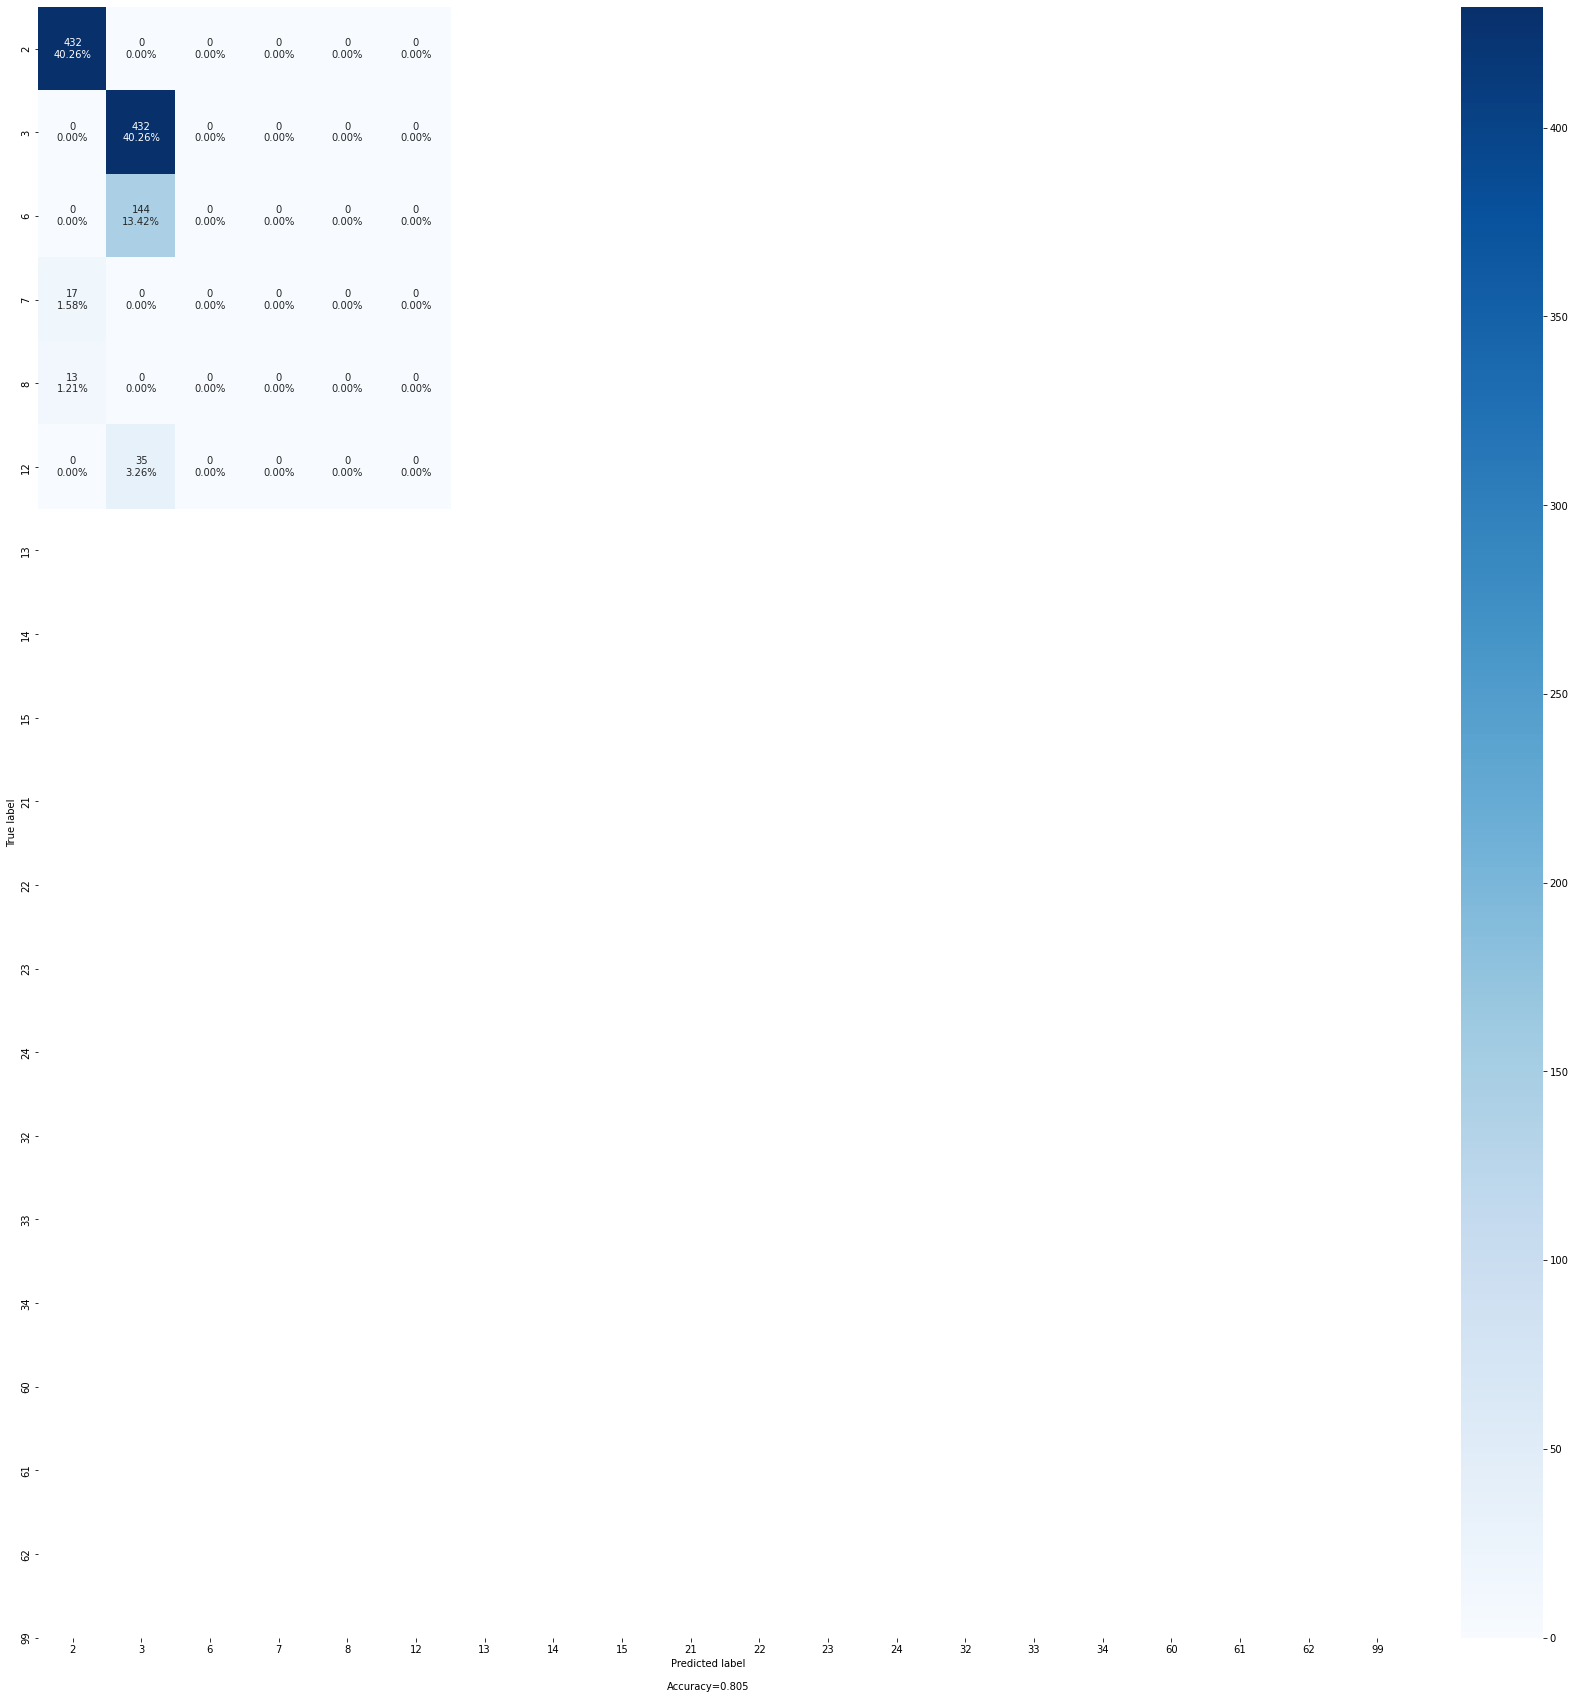

In [17]:
#support vector classifier
print("Support vector classifier")
from sklearn.svm import SVC
categories = ['2', '3', '6', '7', '8', '12', '13', '14','15','21','22','23','24','32','33','34','60','61','62','99']

params_svc = {'gamma':[pow(10,i) for i in range(2,-6, -1)], 'C':[pow(10,j) for j in range(-1, 6, 1)]}
# params_svc = {'gamma':[10000, 1000, 100, 10, 1, 0.1, 0.01],'C':[0.001, 0.01, 0.1, 1, 10, 100]}

best_SVC, SVC_scoring = outer_cross_val(X, Y, StratifiedKFold(), SVC(), params_svc, 'Classification')

SVC_score, average_SVC, SVC_cm, Y_test, Y_pred = SVC_scoring

print("best score - accuracy: %.6f" % SVC_score)
print("average score: %.6f " % average_SVC)
print("Consolidated Confusion Matrix ")
print(SVC_cm)
print(type(SVC_cm))
print("Overall accuracy %.8f"%(accuracy_from_confusion_matrix(SVC_cm)))
print(metrics.classification_report(Y_test, Y_pred))
best_SVC_kappa = metrics.cohen_kappa_score(Y_test, Y_pred)
print("Cohen Kappa: %.6f" % best_SVC_kappa)
print(best_SVC)
make_confusion_matrix(SVC_cm, categories = categories, figsize=(30,30))

###MM

In [ ]:
data_arr = df.to_numpy()
X = data_arr[:, [0, 2, 3, 4, 5, 6, 7]]
Y = data_arr[:, 1]

In [ ]:
#support vector classifier
print("Support vector classifier")
from sklearn.svm import SVC

params_svc = {'gamma':[pow(10,i) for i in range(2,-6, -1)], 'C':[pow(10,j) for j in range(-1, 6, 1)]}
# params_svc = {'gamma':[10000, 1000, 100, 10, 1, 0.1, 0.01],'C':[0.001, 0.01, 0.1, 1, 10, 100]}

best_SVC, SVC_scoring = outer_cross_val(X, Y, StratifiedKFold(), SVC(), params_svc, 'Classification')

SVC_score, average_SVC, SVC_cm, Y_test, Y_pred = SVC_scoring

print("best score - accuracy: %.6f" % SVC_score)
print("average score: %.6f " % average_SVC)
print("Consolidated Confusion Matrix ")
print(SVC_cm)
print("Overall accuracy %.8f"%(accuracy_from_confusion_matrix(SVC_cm)))
print(metrics.classification_report(Y_test, Y_pred))
best_SVC_kappa = metrics.cohen_kappa_score(Y_test, Y_pred)
print("Cohen Kappa: %.6f" % best_SVC_kappa)
print(best_SVC)

###shader

In [ ]:
data_arr = df.to_numpy()
X = data_arr[:, [0, 1, 3, 4, 5, 6, 7, 8]]
Y = data_arr[:, 2]

In [ ]:
#support vector classifier
print("Support vector classifier")
from sklearn.svm import SVC

params_svc = {'gamma':[pow(10,i) for i in range(6,-6, -1)], 'C':[pow(10,j) for j in range(-6, 6, 1)]}
# params_svc = {'gamma':[10000, 1000, 100, 10, 1, 0.1, 0.01],'C':[0.001, 0.01, 0.1, 1, 10, 100]}

best_SVC, SVC_scoring = outer_cross_val(X, Y, StratifiedKFold(), SVC(), params_svc, 'Classification')

SVC_score, average_SVC, SVC_cm, Y_test, Y_pred = SVC_scoring

print("best score - accuracy: %.6f" % SVC_score)
print("average score: %.6f " % average_SVC)
print("Consolidated Confusion Matrix ")
print(SVC_cm)
print("Overall accuracy %.8f"%(accuracy_from_confusion_matrix(SVC_cm)))
print(metrics.classification_report(Y_test, Y_pred))
best_SVC_kappa = metrics.cohen_kappa_score(Y_test, Y_pred)
print("Cohen Kappa: %.6f" % best_SVC_kappa)
print(best_SVC)

###core

In [ ]:
params_svc = {'gamma':[pow(10,i) for i in range(6,-6, -1)], 'C':[pow(10,j) for j in range(-6, 6, 1)]}
print(params_svc)

In [ ]:
data_arr = df.to_numpy()
X = data_arr[:, [0, 1, 2, 4, 5, 6, 7]]
Y = data_arr[:, 3]

In [ ]:
#support vector classifier
print("Support vector classifier")
from sklearn.svm import SVC

# params_svc = {'gamma':[pow(10,i) for i in range(6,-6, -1)], 'C':[pow(10,j) for j in range(-6, 6, 1)]}
params_svc = {'gamma':[10000, 1000, 100, 10, 1, 0.1, 0.01],'C':[0.001, 0.01, 0.1, 1, 10, 100]}

best_SVC, SVC_scoring = outer_cross_val(X, Y, LeaveOneOut(), SVC(), params_svc, 'Classification')

SVC_score, average_SVC, SVC_cm, Y_test, Y_pred = SVC_scoring

print("best score - accuracy: %.6f" % SVC_score)
print("average score: %.6f " % average_SVC)
print("Consolidated Confusion Matrix ")
print(SVC_cm)
print("Overall accuracy %.8f"%(accuracy_from_confusion_matrix(SVC_cm)))
print(metrics.classification_report(Y_test, Y_pred))
best_SVC_kappa = metrics.cohen_kappa_score(Y_test, Y_pred)
print("Cohen Kappa: %.6f" % best_SVC_kappa)
print(best_SVC)

###L1

In [ ]:
params_svc = {'gamma':[pow(10,i) for i in range(0, -10, -1)], 'C':[pow(10,j) for j in range(-10, 1, 1)]}
print(params_svc)

In [ ]:
data_arr = df.to_numpy()
X = data_arr[:, [0, 1, 2, 3, 4, 6, 7, 8]]
Y = data_arr[:, 5]

In [ ]:
#support vector classifier
print("Support vector classifier")
from sklearn.svm import SVC

params_svc = {'gamma':[pow(10,i) for i in range(0, -10, -1)], 'C':[pow(10,j) for j in range(0, 10, 1)]}
# params_svc = {'gamma':[10000, 1000, 100, 10, 1, 0.1, 0.01],'C':[0.001, 0.01, 0.1, 1, 10, 100]}

best_SVC, SVC_scoring = outer_cross_val(X, Y, StratifiedKFold(), SVC(), params_svc, 'Classification')

SVC_score, average_SVC, SVC_cm, Y_test, Y_pred = SVC_scoring

print("best score - accuracy: %.6f" % SVC_score)
print("average score: %.6f " % average_SVC)
print("Consolidated Confusion Matrix ")
print(SVC_cm)
print("Overall accuracy %.8f"%(accuracy_from_confusion_matrix(SVC_cm)))
print(metrics.classification_report(Y_test, Y_pred))
best_SVC_kappa = metrics.cohen_kappa_score(Y_test, Y_pred)
print("Cohen Kappa: %.6f" % best_SVC_kappa)
print(best_SVC)

###L2

In [ ]:
data_arr = df.to_numpy()
X = data_arr[:, [0, 1, 2, 3, 4, 5, 7]]
Y = data_arr[:, 6]

In [ ]:
#support vector classifier
print("Support vector classifier")
from sklearn.svm import SVC

# params_svc = {'gamma':[pow(10,i) for i in range(2,-6, -1)], 'C':[pow(10,j) for j in range(-1, 6, 1)]}
params_svc = {'gamma':[10000, 1000, 100, 10, 1, 0.1, 0.01],'C':[0.001, 0.01, 0.1, 1, 10, 100]}

best_SVC, SVC_scoring = outer_cross_val(X, Y, KFold(), SVC(), params_svc, 'Classification')

SVC_score, average_SVC, SVC_cm, Y_test, Y_pred = SVC_scoring

print("best score - accuracy: %.6f" % SVC_score)
print("average score: %.6f " % average_SVC)
print("Consolidated Confusion Matrix ")
print(SVC_cm)
print("Overall accuracy %.8f"%(accuracy_from_confusion_matrix(SVC_cm)))
print(metrics.classification_report(Y_test, Y_pred))
best_SVC_kappa = metrics.cohen_kappa_score(Y_test, Y_pred)
print("Cohen Kappa: %.6f" % best_SVC_kappa)
print(best_SVC)